<a href="https://colab.research.google.com/github/davidorusjr/Supervised-Learning-Models-for-Precise-Agricultural-Yield-Forecasting/blob/main/A_Comparative_Analysis_of_Supervised_Learning_Models_for_Precise_Agricultural_Yield_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/content/crop_yield_data.csv')
print(data.head())

   rainfall_mm  soil_quality_index  farm_size_hectares  sunlight_hours  \
0         1626                   9                 636              11   
1         1959                   9                  73              11   
2         1360                   1                 352               5   
3         1794                   2                 948               7   
4         1630                   5                 884               5   

   fertilizer_kg  crop_yield  
0           1006         404  
1            112         115  
2            702         231  
3            299         537  
4           2733         554  


In [4]:
# Sorting missing values
data = data.apply(lambda col: col.fillna(col.mean()), axis=0)



In [5]:
# Sorting duplicates
data = data.drop_duplicates().reset_index(drop=True)


In [6]:
# Feature traget separation
X = data.drop(columns='crop_yield').values
y = data['crop_yield'].values.reshape(-1, 1)


In [7]:
print(data.describe())
print(data.info())

       rainfall_mm  soil_quality_index  farm_size_hectares  sunlight_hours  \
count  3000.000000         3000.000000         3000.000000     3000.000000   
mean   1263.095000            5.506667          498.801000        7.995333   
std     432.371756            2.855172          287.122742        2.621501   
min     500.000000            1.000000           10.000000        4.000000   
25%     896.000000            3.000000          242.000000        6.000000   
50%    1277.000000            6.000000          505.000000        8.000000   
75%    1636.000000            8.000000          741.000000       10.000000   
max    2000.000000           10.000000         1000.000000       12.000000   

       fertilizer_kg   crop_yield  
count    3000.000000  3000.000000  
mean     1549.450333   328.099000  
std       814.326919   145.036503  
min       100.000000    46.000000  
25%       869.750000   199.000000  
50%      1542.000000   332.000000  
75%      2225.000000   455.000000  
max      

In [9]:
# Implementing Z score normalization
class StandardScalerScratch:
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1

    def transform(self, X):
        return (X - self.mean) / self.std

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [10]:
# Train-Test Split
def train_test_split(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(X))
    split = int(len(X) * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:
# Applying scaling
scaler = StandardScalerScratch()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# Evaluating metrics
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot


In [13]:
# Linear Regression
class LinearRegressionScratch:
    def __init__(self, lr=0.01, epochs=2000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        self.theta = np.zeros((X.shape[1], 1))

        for _ in range(self.epochs):
            gradients = (2 / len(y)) * X.T @ (X @ self.theta - y)
            self.theta -= self.lr * gradients

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X @ self.theta


In [14]:
# Decision Tree
class DecisionTreeScratch:
    def __init__(self, max_depth=6, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importances_ = None # Initialize feature importances

    def build(self, X, y, depth=0):
        if self.feature_importances_ is None:
            self.feature_importances_ = np.zeros(X.shape[1])

        if len(y) < self.min_samples or depth == self.max_depth:
            return np.mean(y)

        best_feature, best_threshold, best_mse = None, None, float('inf')
        parent_mse = np.var(y) # Calculate parent impurity

        for feature in range(X.shape[1]):
            for threshold in np.unique(X[:, feature]):
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                left = y[left_mask]
                right = y[right_mask]

                if len(left) == 0 or len(right) == 0:
                    continue

                current_mse = (np.var(left) * len(left) + np.var(right) * len(right)) / len(y)

                if current_mse < best_mse:
                    best_feature, best_threshold, best_mse = feature, threshold, current_mse

        if best_feature is None:
            return np.mean(y)

        # Calculate impurity reduction and add to feature importances
        impurity_reduction = parent_mse - best_mse
        self.feature_importances_[best_feature] += impurity_reduction

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self.build(X[left_mask], y[left_mask], depth + 1),
            'right': self.build(X[right_mask], y[right_mask], depth + 1)
        }

In [15]:
# Random Forest
class RandomForestScratch:
    def __init__(self, n_trees=20):
        self.n_trees = n_trees
        self.trees = []
        self.feature_importances_ = None

    def fit(self, X, y):
        self.trees = []
        self.feature_importances_ = np.zeros(X.shape[1])
        for _ in range(self.n_trees):
            idx = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTreeScratch()
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
            # Aggregate feature importances from each tree
            if tree.feature_importances_ is not None:
                self.feature_importances_ += tree.feature_importances_
        # Normalize feature importances
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)

In [17]:
# Training and the final evaluation
models = {
    "Linear Regression": LinearRegressionScratch(),
    "Decision Tree": DecisionTreeScratch(),
    "Random Forest": RandomForestScratch()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append([
        name,
        rmse(y_test, preds),
        mae(y_test, preds),
        r2(y_test, preds)
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "RMSE", "MAE", "R²"]
).sort_values(by="R²", ascending=False)

results_df


/tmp/ipython-input-442676838.py:12: RuntimeWarning: overflow encountered in matmul
  gradients = (2 / len(y)) * X.T @ (X @ self.theta - y)
/tmp/ipython-input-442676838.py:13: RuntimeWarning: invalid value encountered in subtract
  self.theta -= self.lr * gradients


AttributeError: 'DecisionTreeScratch' object has no attribute 'fit'

In [ ]:
# Adding graphical evaluation

# Model Performance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

metrics = []

for name, model in models.items():
    preds = model.predict(X_test)
    metrics.append([
        name,
        rmse(y_test, preds),
        mae(y_test, preds),
        r2(y_test, preds)
    ])

results_df = pd.DataFrame(
    metrics,
    columns=["Model", "RMSE", "MAE", "R2"]
)


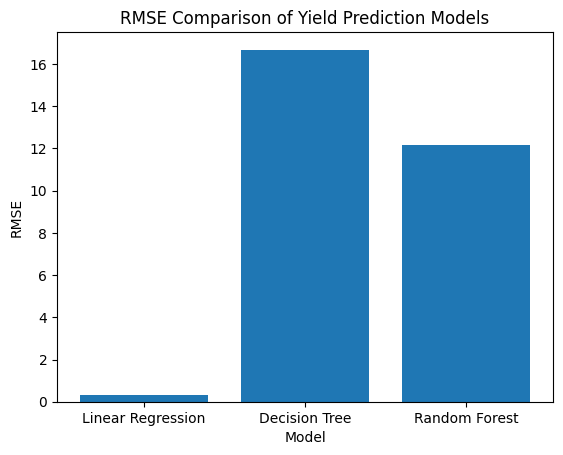

In [ ]:
#RMSE Comparison
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Yield Prediction Models")
plt.show()


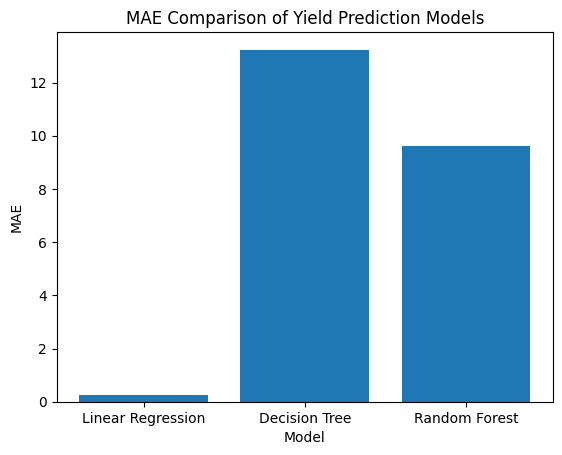

In [ ]:
#MAE Comparison
plt.figure()
plt.bar(results_df["Model"], results_df["MAE"])
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("MAE Comparison of Yield Prediction Models")
plt.show()


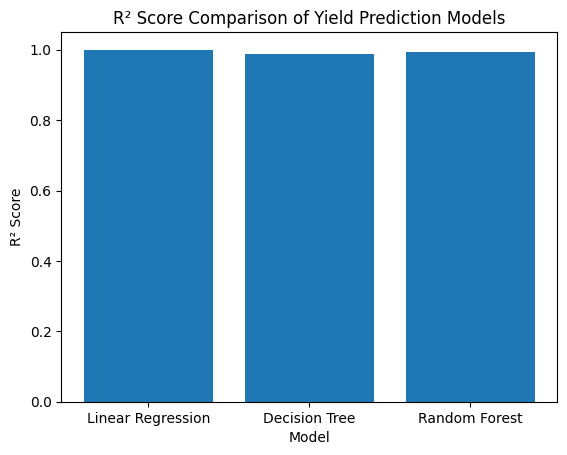

In [ ]:
#R2 COMPARISON
plt.figure()
plt.bar(results_df["Model"], results_df["R2"])
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("R² Score Comparison of Yield Prediction Models")
plt.show()


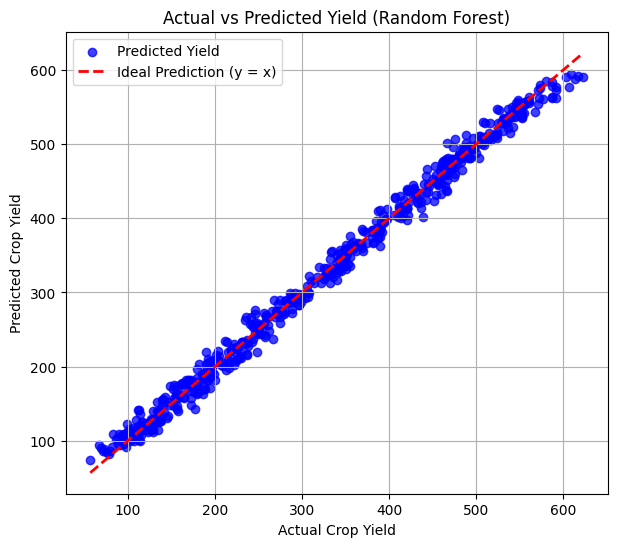

In [ ]:
BEST_MODEL_NAME = "Random Forest"
BEST_MODEL = models[BEST_MODEL_NAME]


y_pred = BEST_MODEL.predict(X_test)

plt.figure(figsize=(7, 6))

plt.scatter(
    y_test,
    y_pred,
    color="blue",
    marker="o",
    alpha=0.75,
    label="Predicted Yield"
)

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Prediction (y = x)"
)

plt.xlabel("Actual Crop Yield")
plt.ylabel("Predicted Crop Yield")
plt.title(f"Actual vs Predicted Yield ({BEST_MODEL_NAME})")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for name, model in models.items():
    preds = model.predict(X_test)
    print(name, np.unique(np.round(preds, 4))[:5])


Linear Regression [56.6072 67.3855 68.6622 71.1196 72.6604]
Decision Tree [ 63.8095  80.5625  89.9231  96.6042 110.2857]
Random Forest [73.898  82.1945 85.3125 86.8684 89.0955]


In [ ]:
for name, model in models.items():
    preds = model.predict(X_test)
    print(
        name,
        f"R2 = {r2(y_test, preds):.10f}"
    )


Linear Regression R2 = 0.9999962076
Decision Tree R2 = 0.9879160524
Random Forest R2 = 0.9935489629


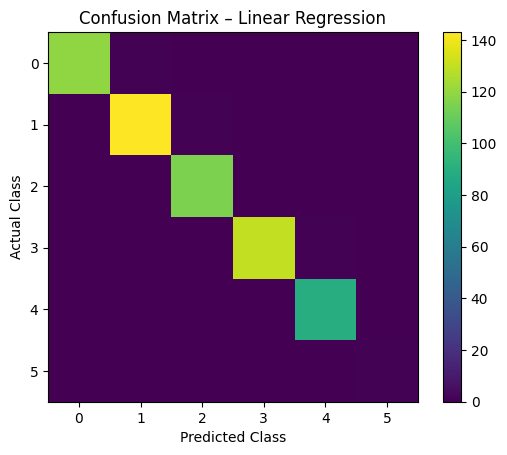

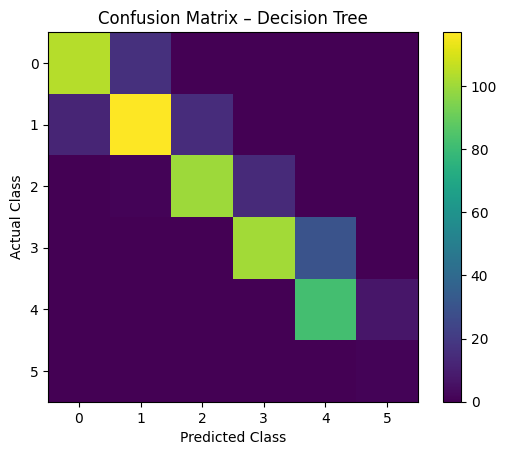

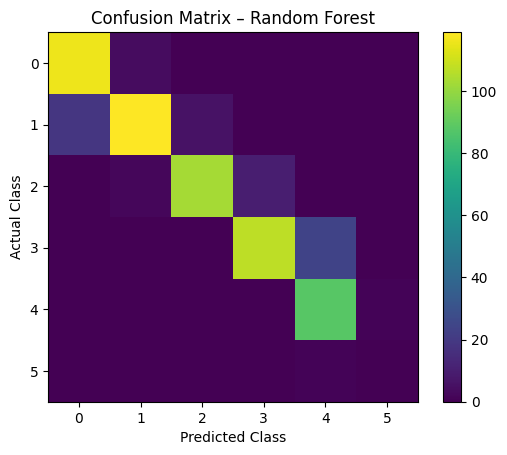

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def bin_yield(y, bins=5):
    return np.digitize(y, bins=np.linspace(y.min(), y.max(), bins + 1))

def plot_confusion(cm, title):
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.colorbar()
    plt.show()

y_test_cls = bin_yield(y_test)

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_cls = bin_yield(y_pred)

    cm = confusion_matrix(y_test_cls, y_pred_cls)
    plot_confusion(cm, f"Confusion Matrix – {name}")

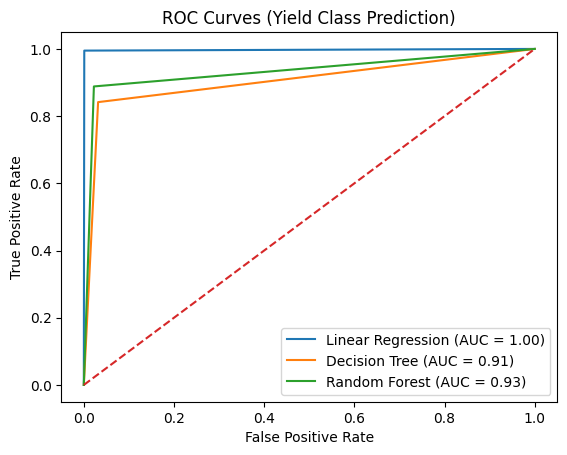

In [ ]:
#ROC Curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = np.unique(y_test_cls)
y_test_bin = label_binarize(y_test_cls, classes=classes)

plt.figure()

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_cls = bin_yield(y_pred)
    y_pred_bin = label_binarize(y_pred_cls, classes=classes)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Yield Class Prediction)")
plt.legend()
plt.show()
